In [1]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models

from torch.utils.data import DataLoader
import torch.nn as nn
import torch

import random
import os, shutil
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

In [2]:
batch_size = 32
img_size = 224, 224

In [3]:
metrics = ["epoch", "accuracy", "precision", "recall", "f1_score"]

metrics_conv = pd.DataFrame(columns=metrics)
metrics_tran = pd.DataFrame(columns=metrics)

In [4]:
def make_dataset(src, classes, val_ratio = 13, test_ratio = 7):

    dirs = ["dataset", "dataset/train", "dataset/val", "dataset/test"]
    class_dirs = [path + '/' + name for name in classes for path in dirs[1:]]
    dirs.extend(class_dirs)

    for dir in dirs:
        os.mkdir(dir)


    dest: str
    num_of_img = 0

    for dir in os.listdir(src):
        src_path = os.path.join(src, dir)

        dest = "test"
        for cls in classes:
            if dir.find(cls) != -1:
                dest = cls
                break

        if dest == "test":
            continue

        print(dir, end=' ')
        cur = num_of_img

        for pic in os.listdir(src_path):
            if num_of_img % test_ratio == 0:
                dest_path = "dataset/test"
            elif num_of_img % val_ratio == 0:
                dest_path = "dataset/val"
            else:
                dest_path = "dataset/train"

            num_of_img += 1
            

            shutil.copy2(
                src=os.path.join(src_path, pic), 
                dst=os.path.join(dest_path, f"{dest}/{num_of_img}{pic}")
                )
        print(f"{num_of_img - cur} pics")
    
    print(f"Total: {num_of_img}")

In [5]:
class_names = ["car", "motorbike", "bike", "person"]

if not os.path.isdir("dataset"):
    make_dataset(src="VOC2005_1/PNGImages", classes=class_names)

In [6]:
def show_some_pics(dataset, num_images=10, denormalize=True, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    indices = random.sample(range(len(dataset)), num_images)

    n_cols = 5
    n_rows = num_images // n_cols + int(num_images % n_cols != 0)

    _, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

    if n_rows == 1:
        axs = axs.flatten()
    else:
        axs = [ax for row in axs for ax in row]

    for ax, idx in zip(axs, indices):
        image, label = dataset[idx]
        if denormalize:
            image_denorm = image.clone()
            for t, m, s in zip(image_denorm, mean, std):
                t.mul_(s).add_(m)
            image_denorm = image_denorm.clamp(0, 1)
        else:
            image_denorm = image

        image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
        ax.imshow(image_np)
        ax.set_title(dataset.classes[label])
        ax.axis('off')

    for ax in axs[len(indices):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
train_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [8]:
train_dataset, val_dataset, test_dataset = \
    ImageFolder(root="dataset/train", transform=train_transform), \
    ImageFolder(root="dataset/val", transform=val_transform), \
    ImageFolder(root="dataset/val", transform=val_transform)

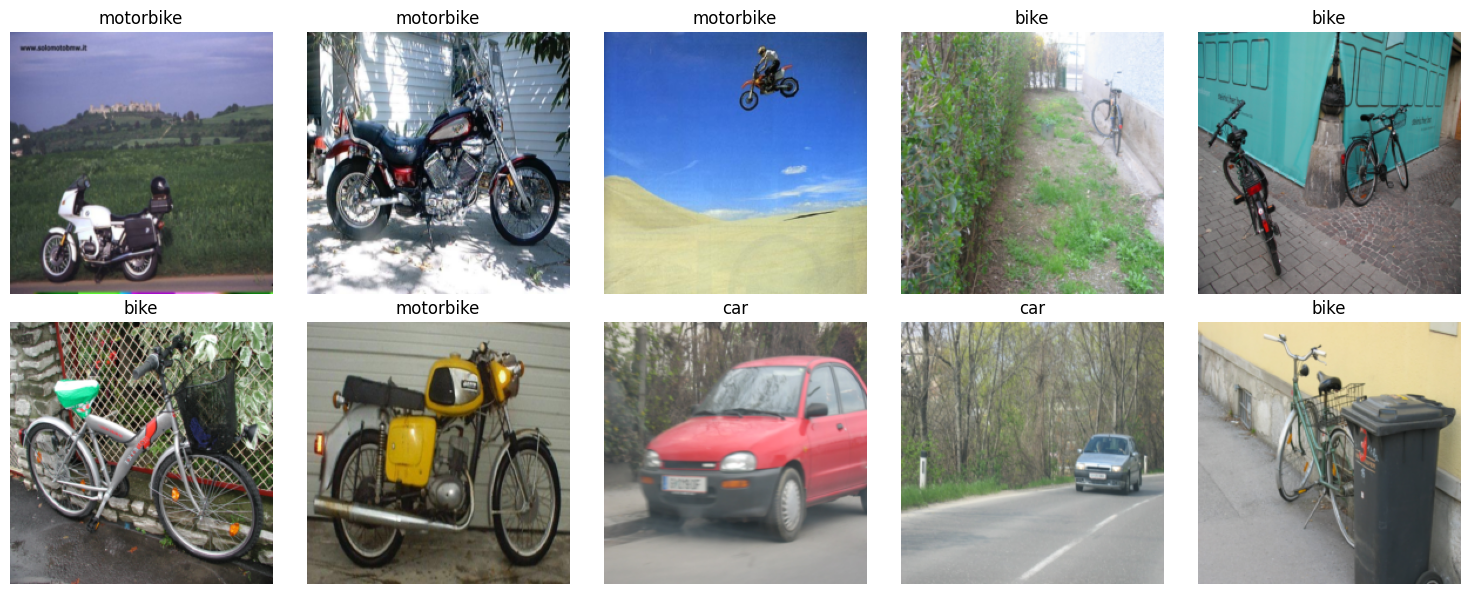

In [9]:
show_some_pics(dataset=train_dataset)

In [ ]:
dataloaders = {
    "train" : DataLoader(train_dataset, batch_size=batch_size, shuffle=True ),
    "val"   : DataLoader(val_dataset,   batch_size=batch_size, shuffle=False),
    "test"  : DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

In [11]:
resnet_model = models.resnet18(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(class_names))

for name, param in resnet_model.named_parameters():
    if "fc" not in name: param.requires_grad = False

resnet_model.to(device)

criterion_conv = nn.CrossEntropyLoss()
optimizer_conv = torch.optim.SGD(resnet_model.fc.parameters(), lr=0.001, momentum=0.9)

c:\Users\ituli\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ituli\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
vit_model = models.vit_b_16(pretrained=True)
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, 4)

for name, param in vit_model.named_parameters():
    if "heads.head" not in name: param.requires_grad = False

vit_model.to(device)

criterion_tran = nn.CrossEntropyLoss()
optimizer_tran = torch.optim.AdamW(vit_model.parameters(), lr=3e-5, weight_decay=1e-4)

c:\Users\ituli\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, metrics, num_epochs=3):
    for epoch in range(num_epochs):
        print(f"Epoch #{epoch+1}", '='*25)

        for phase in ["train", "val"]:
            epoch_size = 0

            epoch_labels = torch.Tensor()
            epoch_preds = torch.Tensor()

            if phase == "train": model.train()
            else: model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                epoch_size += len(labels.data)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == "val":
                    epoch_labels = torch.cat((epoch_labels, torch.Tensor(labels.to("cpu").data)), 0)
                    epoch_preds = torch.cat((epoch_preds, torch.Tensor(preds.to("cpu"))), 0)

            epoch_loss = running_loss / epoch_size
            epoch_acc = running_corrects.double() / epoch_size
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == "val":
                epoch_metrics = {
                    'epoch'         : epoch + 1,
                    'accuracy'      : accuracy_score (epoch_labels, epoch_preds),
                    'precision'     : precision_score(epoch_labels, epoch_preds, average='macro'),
                    'recall'        : recall_score   (epoch_labels, epoch_preds, average='macro'),
                    'f1_score'      : f1_score       (epoch_labels, epoch_preds, average='macro'),
                }
                metrics.loc[len(metrics)] = epoch_metrics

            

In [14]:
train_model(resnet_model, dataloaders, criterion_conv, optimizer_conv, metrics_conv, num_epochs=10)

Epoch #0 =========================
train Loss: 0.9514 Acc: 0.6176
val Loss: 0.5018 Acc: 0.8442
Epoch #1 =========================
train Loss: 0.3767 Acc: 0.9270
val Loss: 0.3194 Acc: 0.9091
Epoch #2 =========================
train Loss: 0.2616 Acc: 0.9444
val Loss: 0.2676 Acc: 0.9091
Epoch #3 =========================
train Loss: 0.2066 Acc: 0.9673
val Loss: 0.2525 Acc: 0.9351
Epoch #4 =========================
train Loss: 0.2018 Acc: 0.9564
val Loss: 0.2296 Acc: 0.9351
Epoch #5 =========================
train Loss: 0.1592 Acc: 0.9630
val Loss: 0.2178 Acc: 0.9351
Epoch #6 =========================
train Loss: 0.1682 Acc: 0.9542
val Loss: 0.2016 Acc: 0.9351
Epoch #7 =========================
train Loss: 0.1487 Acc: 0.9662
val Loss: 0.1924 Acc: 0.9351
Epoch #8 =========================
train Loss: 0.1379 Acc: 0.9695
val Loss: 0.1914 Acc: 0.9351
Epoch #9 =========================
train Loss: 0.1236 Acc: 0.9706
val Loss: 0.1805 Acc: 0.9351


In [15]:
train_model(vit_model, dataloaders, criterion_tran, optimizer_tran, metrics_tran, num_epochs=10)

Epoch #0 =========================


c:\Users\ituli\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


train Loss: 1.3680 Acc: 0.3246
val Loss: 1.2869 Acc: 0.4545
Epoch #1 =========================
train Loss: 1.2275 Acc: 0.5240
val Loss: 1.1603 Acc: 0.5974
Epoch #2 =========================
train Loss: 1.1078 Acc: 0.6449
val Loss: 1.0498 Acc: 0.6883
Epoch #3 =========================
train Loss: 1.0000 Acc: 0.7233
val Loss: 0.9539 Acc: 0.7662
Epoch #4 =========================
train Loss: 0.9062 Acc: 0.7898
val Loss: 0.8707 Acc: 0.8182
Epoch #5 =========================
train Loss: 0.8275 Acc: 0.8257
val Loss: 0.7994 Acc: 0.8442
Epoch #6 =========================
train Loss: 0.7566 Acc: 0.8562
val Loss: 0.7375 Acc: 0.8831
Epoch #7 =========================
train Loss: 0.6936 Acc: 0.8715
val Loss: 0.6828 Acc: 0.8831
Epoch #8 =========================
train Loss: 0.6426 Acc: 0.8900
val Loss: 0.6362 Acc: 0.8831
Epoch #9 =========================
train Loss: 0.5961 Acc: 0.8943
val Loss: 0.5948 Acc: 0.8831


In [16]:
metrics_conv

,epoch,accuracy,precision,recall,f1_score
0,1,0.844156,0.874008,0.780709,0.804274
1,2,0.909091,0.899713,0.880043,0.887411
2,3,0.909091,0.899713,0.880043,0.887411
3,4,0.935065,0.932222,0.907572,0.915810
4,5,0.935065,0.932222,0.907572,0.915810
5,6,0.935065,0.950000,0.904288,0.920447
6,7,0.935065,0.932222,0.907572,0.915810
7,8,0.935065,0.932222,0.907572,0.915810
8,9,0.935065,0.932222,0.907572,0.915810
9,10,0.935065,0.932222,0.907572,0.915810


In [17]:
metrics_tran

,epoch,accuracy,precision,recall,f1_score
0,1,0.454545,0.342449,0.394275,0.362775
1,2,0.597403,0.550417,0.505861,0.493726
2,3,0.688312,0.674837,0.593787,0.597538
3,4,0.766234,0.789850,0.683915,0.702005
4,5,0.818182,0.813928,0.738975,0.750654
5,6,0.844156,0.848800,0.777327,0.794348
6,7,0.883117,0.921007,0.816761,0.836843
7,8,0.883117,0.921007,0.816761,0.836843
8,9,0.883117,0.921007,0.816761,0.836843
9,10,0.883117,0.921007,0.816761,0.836843
